##ThinkDSP

This notebook contains code examples from Chapter 7: Discrete Fourier Transform

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import thinkstats2
import math
import numpy as np

%precision 3
%matplotlib inline

PI2 = 2 * math.pi
i = complex(0, 1)

Here's the definition of ComplexSinusoid, with print statements to display intermediate results.

In [2]:
class ComplexSinusoid(thinkdsp.Sinusoid):
    """Represents a complex exponential signal."""
    
    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        ts: float array of times
        
        returns: float wave array
        """
        print(ts)
        i = complex(0, 1)
        phases = PI2 * self.freq * ts + self.offset
        print(phases)
        ys = self.amp * np.exp(i * phases)
        return ys

Here's an example:

In [3]:
signal = ComplexSinusoid(freq=1, amp=0.6, offset=1)
wave = signal.make_wave(duration=1, framerate=4)
print(wave.ys)

[ 0.    0.25  0.5   0.75]
[ 1.     2.571  4.142  5.712]
[ 0.324+0.505j -0.505+0.324j -0.324-0.505j  0.505-0.324j]


The simplest way to synthesize a mixture of signals is to evaluate the signals and add them up.

In [4]:
def synthesize1(amps, freqs, ts):
    components = [thinkdsp.ComplexSinusoid(freq, amp)
                  for amp, freq in zip(amps, freqs)]
    signal = thinkdsp.SumSignal(*components)
    ys = signal.evaluate(ts)
    return ys

Here's an example that's a mixture of 4 components.

In [5]:
amps = np.array([0.6, 0.25, 0.1, 0.05])
freqs = [100, 200, 300, 400]
framerate = 11025

ts = np.linspace(0, 1, framerate)
ys = synthesize1(amps, freqs, ts)
print(ys)

[ 1.000 +0.000e+00j  0.995 +9.093e-02j  0.979 +1.803e-01j ...,
  0.979 -1.803e-01j  0.995 -9.093e-02j  1.000 -5.083e-15j]


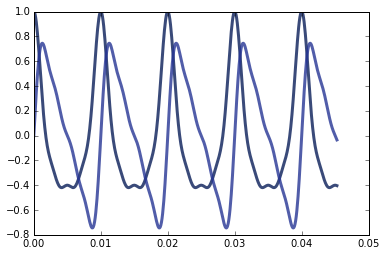

In [6]:
thinkplot.plot(ts[:500], ys[:500].real)
thinkplot.plot(ts[:500], ys[:500].imag)

The real part is a mixture of cosines; the imaginary part is a mixture of sines.

In [7]:
wave = thinkdsp.Wave(ys.real, framerate)
wave.make_audio()

In [8]:
wave = thinkdsp.Wave(ys.imag, framerate)
wave.make_audio()

We can express the same process using matrix multiplication.

In [9]:
PI2 = 2 * math.pi
i = complex(0, 1)
amps = np.array([0.6, 0.25, 0.1, 0.05])

def synthesize2(amps, freqs, ts):
    args = np.outer(ts, freqs)
    M = np.exp(i * PI2 * args)
    ys = np.dot(M, amps)
    return ys

And it should sound the same.

In [10]:
ys = synthesize2(amps, freqs, ts)
print(ys)

[ 1.000 +0.000e+00j  0.995 +9.093e-02j  0.979 +1.803e-01j ...,
  0.979 -1.803e-01j  0.995 -9.093e-02j  1.000 -5.083e-15j]


In [11]:
wave = thinkdsp.Wave(ys.real, framerate)
wave.make_audio()

To see the effect of a complex amplitude, we can rotate the amplitudes by 1 radian:

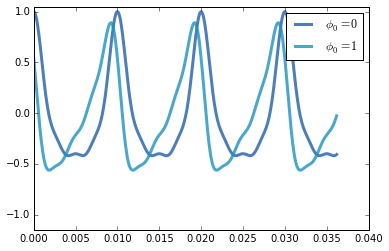

In [12]:
amps2 = amps * np.exp(1j)
ys2 = synthesize2(amps2, freqs, ts)

n=400
thinkplot.plot(ts[:n], ys.real[:n], label=r'$\phi_0 = 0$')
thinkplot.plot(ts[:n], ys2.real[:n], label=r'$\phi_0 = 1$')
thinkplot.config(ylim=[-1.15, 1.05])

Rotating all components by the same phase offset changes the shape of the waveform because the components have different periods; a constant offset has a different effect on each component.

The simplest way to analyze a signal---that is, find the amplitude for each component---is to create the same matrix we used for synthesis and then solve the system of linear equations.

In [13]:
def analyze1(ys, freqs, ts):
    args = np.outer(ts, freqs)
    M = np.exp(i * PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

Using the first 4 values from the wave array, we can recover the amplitudes.

In [14]:
n = len(freqs)
amps2 = analyze1(ys[:n], freqs, ts[:n])
print(amps2)

[ 0.60 +4.658e-13j  0.25 -1.404e-12j  0.10 +1.403e-12j  0.05 -4.643e-13j]


If we define the `freqs` from 0 to N-1 and `ts` from 0 to (N-1)/N, we get a unitary matrix. 

In [15]:
N = 4
ts = np.arange(N) / N
freqs = np.arange(N)
args = np.outer(ts, freqs)
M = np.exp(i * PI2 * args)
print(M)

[[  1.000e+00 +0.000e+00j   1.000e+00 +0.000e+00j   1.000e+00 +0.000e+00j
    1.000e+00 +0.000e+00j]
 [  1.000e+00 +0.000e+00j   6.123e-17 +1.000e+00j  -1.000e+00 +1.225e-16j
   -1.837e-16 -1.000e+00j]
 [  1.000e+00 +0.000e+00j  -1.000e+00 +1.225e-16j   1.000e+00 -2.449e-16j
   -1.000e+00 +3.674e-16j]
 [  1.000e+00 +0.000e+00j  -1.837e-16 -1.000e+00j  -1.000e+00 +3.674e-16j
    5.511e-16 +1.000e+00j]]


To check whether a matrix is unitary, we can compute $M^* M$, which should be the identity matrix:

In [16]:
MstarM = M.conj().transpose().dot(M)
print(MstarM.real)

[[  4.000e+00  -1.837e-16   0.000e+00   3.290e-16]
 [ -1.837e-16   4.000e+00  -1.494e-16  -1.012e-31]
 [  0.000e+00  -1.494e-16   4.000e+00  -1.070e-16]
 [  3.290e-16  -1.012e-31  -1.070e-16   4.000e+00]]


In [17]:
print(MstarM.imag)

[[  0.000e+00   2.220e-16   2.449e-16   3.331e-16]
 [ -2.220e-16   0.000e+00   0.000e+00   2.449e-16]
 [ -2.449e-16  -1.339e-16   4.930e-32   1.992e-16]
 [ -3.331e-16  -2.449e-16  -2.220e-16   0.000e+00]]


The result is actually $4 I$, so in general we have an extra factor of $N$ to deal with, but that's a minor problem.

We can use this result to write a faster version of `analyze1`:


In [18]:
def analyze2(ys, freqs, ts):
    args = np.outer(ts, freqs)
    M = np.exp(i * PI2 * args)
    amps = M.conj().transpose().dot(ys) / N
    return amps

In [19]:
N = 4
amps = np.array([0.6, 0.25, 0.1, 0.05])
freqs = np.arange(N)
ts = np.arange(N) / N
ys = synthesize2(amps, freqs, ts)

amps2 = analyze2(ys, freqs, ts)
print(amps2)

[ 0.60 +2.082e-17j  0.25 +1.388e-17j  0.10 -3.899e-17j  0.05 -8.327e-17j]


Now we can write our own version of DFT:

In [20]:
def synthesis_matrix(N):
    ts = np.arange(N) / N
    freqs = np.arange(N)
    args = np.outer(ts, freqs)
    M = np.exp(i * PI2 * args)
    return M

In [21]:
def dft(ys):
    N = len(ys)
    M = synthesis_matrix(N)
    amps = M.conj().transpose().dot(ys)
    return amps

And compare it to analyze2:

In [22]:
print(dft(ys))

[ 2.4 +8.327e-17j  1.0 +5.551e-17j  0.4 -1.559e-16j  0.2 -3.331e-16j]


The result is close to `amps * 4`.

We can also compare it to `np.fft.fft`.  FFT stands for Fast Fourier Transform, which is an even faster implementation of DFT.

In [23]:
print(np.fft.fft(ys))

[ 2.4 +8.000e-17j  1.0 -2.449e-17j  0.4 -3.102e-17j  0.2 -2.449e-17j]


The inverse DFT is almost the same, except we don't have to transpose $M$ and we have to divide through by $N$.

In [24]:
def idft(ys):
    N = len(ys)
    M = synthesis_matrix(N)
    amps = M.dot(ys) / N
    return amps

We can confirm that `dft(idft(amps))` yields `amps`:

In [25]:
ys = idft(amps)
print(dft(ys))

[ 0.60 +2.082e-17j  0.25 +1.388e-17j  0.10 -3.899e-17j  0.05 -8.327e-17j]


Now let's see what happens when we apply DFT to a real signal.

In [26]:
framerate = 10000
signal = thinkdsp.SawtoothSignal(freq=500)
wave = signal.make_wave(duration=0.1, framerate=framerate)
wave.make_audio()

`wave` is a 500 Hz sawtooth signal sampled at 10 kHz.

In [27]:
hs = dft(wave.ys)
len(wave.ys), len(hs)

(1000, 1000)

`hs` is the DFT of this wave, and `amps` contains the amplitudes.

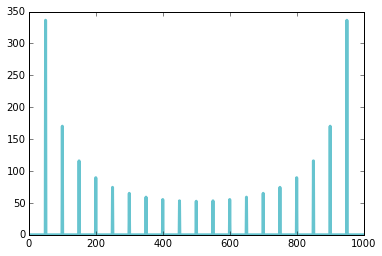

In [28]:
amps = np.absolute(hs)
thinkplot.plot(amps)

The DFT assumes that the sampling rate is N per time unit, for an arbitrary time unit.  We have to convert to actual units -- seconds -- like this:

In [29]:
N = len(hs)
fs = np.arange(N) * framerate / N

Also, the DFT of a real signal is symmetric, so the right side is redundant.  Normally, we only compute and plot the first half:

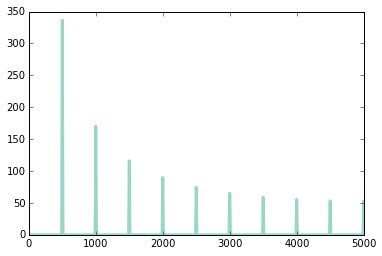

In [30]:
thinkplot.plot(fs[:N//2+1], amps[:N//2+1])

Let's get a better sense for why the DFT of a real signal is symmetric.  I'll start by making the inverse DFT matrix for $N=8$.

In [31]:
M = synthesis_matrix(N=8)

And the DFT matrix:

In [32]:
Mstar = M.conj().transpose()

And a triangle wave with 8 elements:

In [33]:
wave = thinkdsp.TriangleSignal(freq=1).make_wave(duration=1, framerate=8)
wave.ys

array([ 1. ,  0.5,  0. , -0.5, -1. , -0.5,  0. ,  0.5])

Here's what the wave looks like.

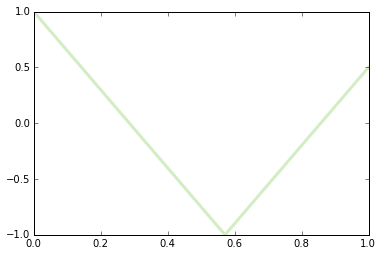

In [34]:
wave.plot()

Now let's look at rows 3 and 5 of the DFT matrix:

In [35]:
row3 = Mstar[3, :]
row3

array([  1.000e+00 -0.000e+00j,  -7.071e-01 -7.071e-01j,
        -1.837e-16 +1.000e+00j,   7.071e-01 -7.071e-01j,
        -1.000e+00 -3.674e-16j,   7.071e-01 +7.071e-01j,
         5.511e-16 -1.000e+00j,  -7.071e-01 +7.071e-01j])

In [36]:
row5 = Mstar[5, :]
row5

array([  1.000e+00 -0.000e+00j,  -7.071e-01 +7.071e-01j,
         3.062e-16 -1.000e+00j,   7.071e-01 +7.071e-01j,
        -1.000e+00 -6.123e-16j,   7.071e-01 -7.071e-01j,
        -2.695e-15 +1.000e+00j,  -7.071e-01 -7.071e-01j])

They are almost the same, but row5 is the complex conjugate of row3.

In [37]:
def approx_equal(a, b, tol=1e-10):
    return sum(abs(a-b)) < tol

In [38]:
approx_equal(row3, row5.conj())

True

When we multiply the DFT matrix and the wave array, the element with index 3 is:

In [39]:
X3 = row3.dot(wave.ys)
X3

(0.58578643762690552-1.1102230246251565e-16j)

And the element with index 5 is:

In [40]:
X5 = row5.dot(wave.ys)
X5

(0.58578643762690619-5.5511151231257827e-16j)

And they are the same, within floating point error.

In [41]:
abs(X3 - X5)

0.000

Let's try the same thing with a complex signal:

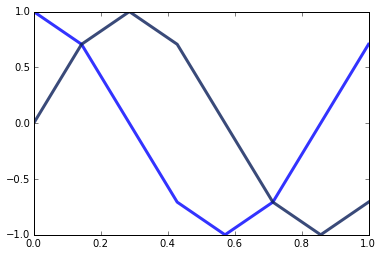

In [42]:
wave2 = thinkdsp.ComplexSinusoid(freq=1).make_wave(duration=1, framerate=8)
thinkplot.plot(wave2.ts, wave2.ys.real)
thinkplot.plot(wave2.ts, wave2.ys.imag)

Now the elements with indices 3 and 5 are different:

In [43]:
X3 = row3.dot(wave2.ys)
X3

(1.3322676295501878e-15-4.4408920985006262e-16j)

In [44]:
X5 = row5.dot(wave2.ys)
X5

3.0384198312040938e-16j

And we can confirm that the FFT of the real signal is symmetric:

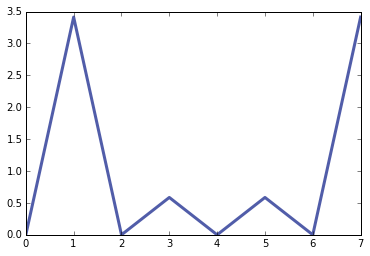

In [45]:
hs = np.fft.fft(wave.ys)
thinkplot.plot(abs(hs))

And the FFT of the complex signal is not.

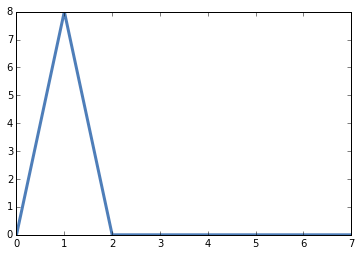

In [46]:
hs = np.fft.fft(wave2.ys)
thinkplot.plot(abs(hs))

Another way to think about all of this is to evaluate the DFT matrix for different frequencies:

In [47]:
N = 8
ts = np.arange(N) / N
freqs = np.arange(N)
freqs = [0, 1, 2, 3, 4, -3, -2, -1]
args = np.outer(ts, freqs)
M2 = np.exp(i * PI2 * args)

In [48]:
approx_equal(M, M2)

array([ True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

So you can think of the second half of the DFT as negative frequencies.  For a real signal, the positive and negative frequencies yield the same result.  For a complex signal, they don't.